In [33]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import OrderedDict
from multiprocessing import Pool
from numba import jit
from tqdm.auto import tqdm
import linearmodels as lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa import arima_process
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)


sns.set_context("paper", font_scale=1.3)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
    },
)

# Import Data

In [2]:
%%time
data_files = glob.glob("../data/returns/ticker_daily_rv/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    # Magic number for the number of observations each file should have
    if len(ticker_df) == 1447:
        ticker_dfs.append(ticker_df)

data_rv_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 3.36 s, sys: 3.91 s, total: 7.27 s
Wall time: 5.16 s


# Clean Data

## Additional Vars

In [3]:
data_rv_df['1'] = 1
data_rv_df['rvol'] = np.sqrt(data_rv_df['rv'])

## Lagged Measures

In [4]:
data_rv_df = data_rv_df.sort_values(by = ['ticker', 'date'])

# Signed Jump variants
data_rv_df['sgn_jump_var_pos'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] > 0)
data_rv_df['sgn_jump_var_neg'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] < 0)

data_rv_df['rq'] = data_rv_df['return_p4']/3
data_rv_df['sqrt_rq'] = np.sqrt(data_rv_df['rq'])

data_rv_df['year'] = data_rv_df['date'].dt.year

In [5]:
# Lags
data_rv_df["rv_d_lag_1"] = data_rv_df["return_d_p2"].shift(1)
data_rv_df["rv_d_lag_m5"] = data_rv_df["rv_lag_1"].rolling(5).mean()
data_rv_df["rv_d_lag_m22"] = data_rv_df["rv_lag_1"].rolling(22).mean()

In [6]:
lag_coeff_cols = [
    "return_j_pos",
    "return_j_neg",
    "return_d_pos",
    "return_d_neg",
    "sum_jump_p2_1",
    "sum_jump_p2_5",
    "sum_jump_p2_22",
    "sum_jump_p2_pos_1",
    "sum_jump_p2_pos_5",
    "sum_jump_p2_pos_22",
    "sum_jump_p2_neg_1",
    "sum_jump_p2_neg_5",
    "sum_jump_p2_neg_22",
    "sgn_jump_var",
    "sgn_jump_var_pos",
    "sgn_jump_var_neg",
    "sqrt_rq",
]

interact_cols = [
    "rv_lag_1",
    "rv_lag_m5",
    "rv_lag_m22",
    "rv_d_lag_1",
    "rv_d_lag_m5",
    "rv_d_lag_m22",
]

for col in tqdm(lag_coeff_cols):
    data_rv_df[col + "_lag_1"] = data_rv_df.groupby("ticker")[col].shift(1)

    for icol in interact_cols:
        data_rv_df[f"{icol}:{col}_lag_1"] = np.multiply(
            data_rv_df[icol], data_rv_df[col + "_lag_1"]
        )

## Rolling Beta

In [7]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [11]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker
    fit_params_df = fit_params_df.reset_index()
    
    return fit_params_df.reset_index()

In [16]:
%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=25),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_beta_df = pd.concat(results)


CPU times: user 1.22 s, sys: 5.31 s, total: 6.53 s
Wall time: 1min 42s


In [17]:
coeff_cols = ["rv_lag_1", "rv_lag_m5", "rv_lag_m22"]
data_rv_df = data_rv_df.merge(
    rolling_beta_df.rename(columns={x: (x + "_rollcoeff") for x in coeff_cols}).drop(
        "Intercept", axis=1
    ),
    on=["date", "ticker"], how = 'left'
)

## Crisis Index

In [18]:
# Persistence
data_rv_df["persistence"] = (
    data_rv_df["rv_lag_1_rollcoeff"]
    + data_rv_df["rv_lag_m5_rollcoeff"]
    + data_rv_df["rv_lag_m22_rollcoeff"]
)

# High Persistence indicator
data_rv_df["indicator_high_beta"] = data_rv_df["persistence"].clip(-3, 3) > 0.6

# Crisis index
data_rv_df["switch"] = (
    data_rv_df.groupby("ticker")["indicator_high_beta"]
    .rolling(22)
    .mean()
    .reset_index(drop=True)
)
data_rv_df["switch_lag_1"] = (
    data_rv_df.groupby("ticker")["switch"].shift(1).reset_index(drop=True)
)

In [19]:
# Crisis Index interaction terms
data_rv_df['switchn'] = 1 - data_rv_df['switch']
data_rv_df['switchn_lag_1'] = 1 - data_rv_df['switch_lag_1']
data_rv_df['bv_lag_1'] = data_rv_df.groupby('ticker')['bipower_var_daily'].shift(1)

interact_cols = [
    'rv_lag_1',
    'rv_lag_m5',
    'rv_lag_m22',
    'rv_d_lag_1',
    'rv_d_lag_m5',
    'rv_d_lag_m22',
    'rv_lag_1:sqrt_rq_lag_1',
    'rv_lag_m5:sqrt_rq_lag_1',
    'rv_lag_m22:sqrt_rq_lag_1',
]

for col in tqdm(interact_cols):
    data_rv_df[f'{col}:switchn_lag_1'] = data_rv_df[col]*data_rv_df['switchn_lag_1']

# Regressions

## Panels

In [20]:
mod = lm.PanelOLS(
    data_rv_df.set_index(["ticker", "date"])["rv"],
    data_rv_df.set_index(["ticker", "date"])[["rv_lag_1", "rv_lag_m5", "rv_lag_m22"]],
)
fit = mod.fit(
    cov_type="kernel",
    **{"kernel": "newey-west"}
)
fit

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,rv,R-squared:,0.4752
Estimator:,PanelOLS,R-squared (Between):,0.9763
No. Observations:,648375,R-squared (Within):,0.4181
Date:,"Sat, Nov 21 2020",R-squared (Overall):,0.4752
Time:,10:00:53,Log-likelihood,3.806e+06
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,1.957e+05
Entities:,455,P-value,0.0000
Avg Obs:,1425.0,Distribution:,"F(3,648372)"
Min Obs:,1425.0,,
Max Obs:,1425.0,F-statistic (robust):,83.460


In [21]:
mod = lm.PanelOLS(
    data_rv_df.set_index(["ticker", "date"])["rv"],
    data_rv_df.set_index(["ticker", "date"])[["switchn_lag_1", "rv_lag_1", "rv_lag_1:switchn_lag_1", 
                                              "rv_lag_m5:switchn_lag_1", "rv_lag_m22:switchn_lag_1"]],
)
fit = mod.fit(
    cov_type="kernel",
    **{"kernel": "newey-west"}
)
fit

Dep. Variable:,rv,R-squared:,0.4850
Estimator:,PanelOLS,R-squared (Between):,0.9924
No. Observations:,648375,R-squared (Within):,0.4273
Date:,"Sat, Nov 21 2020",R-squared (Overall):,0.4850
Time:,10:01:01,Log-likelihood,3.813e+06
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,1.221e+05
Entities:,455,P-value,0.0000
Avg Obs:,1425.0,Distribution:,"F(5,648370)"
Min Obs:,1425.0,,
Max Obs:,1425.0,F-statistic (robust):,165.59


In [22]:
mod = lm.PanelOLS(
    data_rv_df.set_index(["ticker", "date"])["rv"],
    data_rv_df.set_index(["ticker", "date"])[["switchn_lag_1", "rv_lag_1", "rv_lag_1:switchn_lag_1", 
                                              "rv_lag_m5", "rv_lag_m5:switchn_lag_1", 
                                              "rv_lag_m22", "rv_lag_m22:switchn_lag_1"]],
)
fit = mod.fit(
    cov_type="kernel",
    **{"kernel": "newey-west"}
)
fit

Dep. Variable:,rv,R-squared:,0.4938
Estimator:,PanelOLS,R-squared (Between):,0.9929
No. Observations:,648375,R-squared (Within):,0.4370
Date:,"Sat, Nov 21 2020",R-squared (Overall):,0.4938
Time:,10:01:08,Log-likelihood,3.818e+06
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,9.036e+04
Entities:,455,P-value,0.0000
Avg Obs:,1425.0,Distribution:,"F(7,648368)"
Min Obs:,1425.0,,
Max Obs:,1425.0,F-statistic (robust):,245.85


## Full sample estimation of LS model

In [23]:
reg_formula_har = "rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22"

reg_formula_har_ls = """rv ~ np.divide(switchn_lag_1, 1e4)
+ rv_lag_1 + rv_lag_1:switchn_lag_1 + 
rv_lag_m5:switchn_lag_1 + rv_lag_m22:switchn_lag_1"""

reg_formula_har_ls_full = """rv ~ np.divide(switchn_lag_1, 1e4)
+ rv_lag_1 + rv_lag_1:switchn_lag_1 + 
rv_lag_m5 + rv_lag_m5:switchn_lag_1 +
rv_lag_m22 + rv_lag_m22:switchn_lag_1"""

In [24]:
smf.ols(reg_formula_har_ls, data_rv_df.query('ticker == "AMZN"')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rv   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     277.4
Date:                Sat, 21 Nov 2020   Prob (F-statistic):          4.26e-207
Time:                        10:01:12   Log-Likelihood:                 9865.6
No. Observations:                1425   AIC:                        -1.972e+04
Df Residuals:                    1419   BIC:                        -1.969e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      6.712e-05   1.74e-05      3.858      0.000     3.3e-05       0.000
np.divide(switchn_lag_1, 1e4)    -0.3808      0.222     -1.713      0.087      -0.817       0.055
rv_lag_1                          0.7851      0.032     24.570      0.000       0.722       0.848
rv_lag_1:switchn_lag_1           -0.4430      0.060     -7.388      0.000      -0.561      -0.325
rv_lag_m5:switchn_lag_1           0.3084      0.076      4.084      0.000       0.160       0.456
rv_lag_m22:switchn_lag_1          0.1962      0.090      2.171      0.030       0.019       0.373
==============================================================================
Omnibus:                     1305.545   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69038.978
Skew:                           4.105   Prob(JB):                         0.00
Kurtosis:                      36.096   Cond. No.                     3.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
ticker_list = data_rv_df['ticker'].unique()
har_lsparams_results = []

def get_har_ls_params(ticker):

    fit = smf.ols(reg_formula_har_ls, data_rv_df.query('ticker == @ticker')).fit()
    result = fit.params[1:]
    result.index = ['harls_coeff_' + x for x in result.index]
    result['ticker'] = ticker
    result['rsquared_har_ls'] = fit.rsquared
    result['aic_har_ls'] = fit.aic
    
    fit = smf.ols(reg_formula_har, data_rv_df.query('ticker == @ticker')).fit()
    temp = fit.params[1:]
    temp.index = ['har_coeff_' + x for x in temp.index]
    result = result.append(temp)
    result['rsquared_har'] = fit.rsquared
    result['aic_har'] = fit.aic
    
    
    fit = smf.ols(reg_formula_har_ls_full, data_rv_df.query('ticker == @ticker')).fit()
    temp = fit.params[1:]
    temp.index = ['harlsf_coeff_' + x for x in temp.index]
    result = result.append(temp)
    result['rsquared_har_lsf'] = fit.rsquared
    result['aic_har_lsf'] = fit.aic
    
    return result

with Pool(8) as p:
    
    for result in tqdm(p.imap_unordered(get_har_ls_params, ticker_list), total = len(ticker_list)):

        har_lsparams_results.append(result)

In [26]:
results_df = pd.DataFrame(har_lsparams_results).set_index('ticker')
results_df.head()

,"harls_coeff_np.divide(switchn_lag_1, 1e4)",harls_coeff_rv_lag_1,harls_coeff_rv_lag_1:switchn_lag_1,harls_coeff_rv_lag_m5:switchn_lag_1,harls_coeff_rv_lag_m22:switchn_lag_1,rsquared_har_ls,aic_har_ls,har_coeff_rv_lag_1,har_coeff_rv_lag_m5,har_coeff_rv_lag_m22,...,aic_har,"harlsf_coeff_np.divide(switchn_lag_1, 1e4)",harlsf_coeff_rv_lag_1,harlsf_coeff_rv_lag_1:switchn_lag_1,harlsf_coeff_rv_lag_m5,harlsf_coeff_rv_lag_m5:switchn_lag_1,harlsf_coeff_rv_lag_m22,harlsf_coeff_rv_lag_m22:switchn_lag_1,rsquared_har_lsf,aic_har_lsf
ticker,,,,,,,,,,,,,,,,,,,,,
AAL,-2.988489,0.780137,-0.897515,1.019260,0.053739,0.551628,-14975.514537,0.387167,0.448971,0.024811,...,-14997.749479,-2.085016,0.505374,-0.357554,0.320290,0.423092,0.000445,0.053369,0.561256,-15002.446937
A,-0.236230,0.849597,-0.779728,0.811719,0.151023,0.607496,-20074.560108,0.336020,0.578722,-0.085861,...,-20048.079938,-0.770960,0.589938,-0.474680,0.423448,0.185029,-0.290288,0.886482,0.615776,-20100.943902
ABT,-1.304610,0.502972,-0.262441,0.915505,0.403765,0.595900,-19864.668464,0.420253,0.438919,-0.019970,...,-19810.739416,-1.220113,0.496718,-0.255242,-0.025227,0.982190,0.046995,0.272099,0.596103,-19861.382194
ABBV,0.409967,0.947694,-0.927580,0.358169,0.466820,0.415328,-18138.397326,0.331407,0.385162,0.049900,...,-18025.599171,0.317447,1.083692,-1.098226,-0.154878,0.557847,0.002296,0.457472,0.417053,-18138.608474
AAPL,-0.855792,0.669138,-0.394926,0.289605,0.371497,0.413443,-19163.878901,0.365939,0.384286,0.059909,...,-19228.575042,-0.393249,0.353788,0.030720,0.475237,-0.364402,-0.031673,0.422210,0.442551,-19232.408717


## Distribution of HAR-LS Coefficients

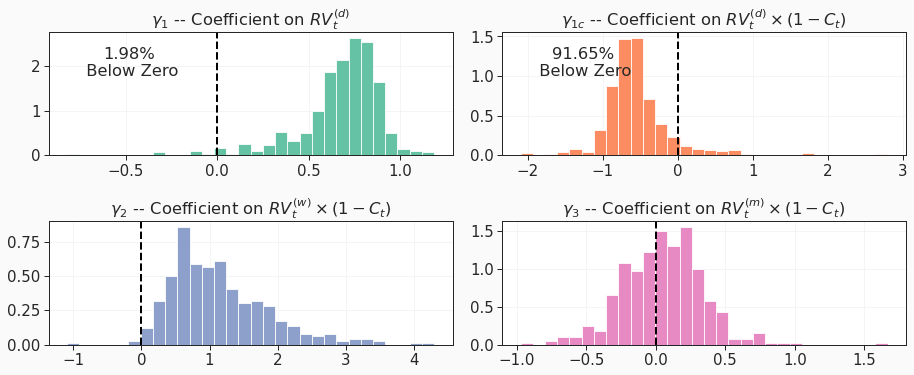

In [27]:
reg_cols = [x for x in results_df.columns if "harls_coeff_" in x if 'rv' in x]
reg_col_names = [
    "$\\gamma_1$ -- Coefficient on $RV_{t}^{(d)}$",
    "$\\gamma_{1c}$ -- Coefficient on $RV_{t}^{(d)} \\times (1-C_t)$",
    "$\\gamma_{2}$ -- Coefficient on $RV_{t}^{(w)} \\times (1-C_t)$",
    "$\\gamma_{3}$ -- Coefficient on $RV_{t}^{(m)} \\times (1-C_t)$",
]

fig, axs = plt.subplots(figsize=(13, 5.5), nrows=2, ncols=2)
pal = sns.color_palette("Set2", 4)

for i in range(len(reg_cols)):

    col = reg_cols[i]
    ax = axs.reshape(-1)[i]

    if i <= 1:
        ax.text(
            0.2, 0.75,
            f"{np.mean(results_df[col]<0):0.2%}\n Below Zero",
            ha="center",
            va="center",
            transform=ax.transAxes,
        )

    ax.hist(results_df[col], color=pal[i], bins=30, density = True)
    ax.axvline(0, 0, 1, color="k", ls="dashed", lw=2)
#     ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0, decimals = 0))
    ax.set_title(reg_col_names[i])

plt.tight_layout()
plt.savefig('../exhibits/harlsm_coeff_dist.pdf')

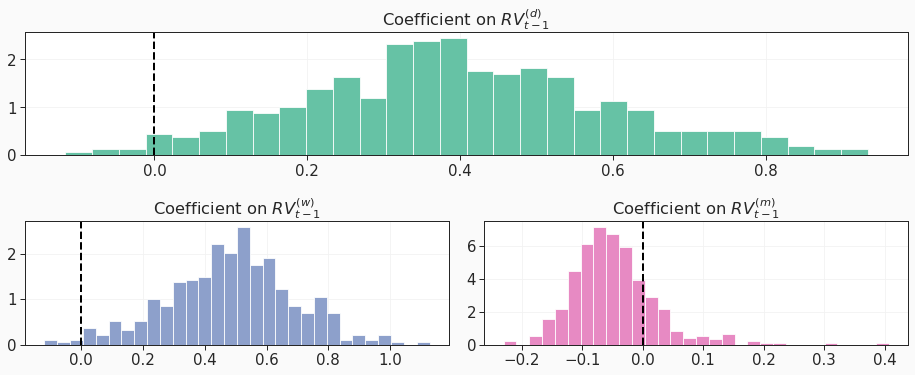

In [28]:
reg_cols = [x for x in results_df.columns if "har_coeff_" in x]
reg_col_names = [
    "Coefficient on $RV_{t-1}^{(d)}$",
    "",
    "Coefficient on $RV_{t-1}^{(w)}$",
    "Coefficient on $RV_{t-1}^{(m)}$",
]

fig, axs = plt.subplots(figsize=(13, 5.5), nrows=2, ncols=2)
grid = plt.GridSpec(2, 2)
pal = sns.color_palette("Set2", 4)

for i in range(len(reg_cols)):

    col = reg_cols[i]
    
    if i == 0: 
        ax = plt.subplot(grid[0,:])
    else:
        i = i + 1
        ax = axs.reshape(-1)[i]

    ax.hist(results_df[col], color=pal[i], bins=30, density = True)
    ax.axvline(0, 0, 1, color="k", ls="dashed", lw=2)
    ax.set_title(reg_col_names[i])

plt.tight_layout()
plt.savefig('../exhibits/har_coeff_dist.pdf')

## Distribution of R2 and AIC

In [43]:
r2_perf = np.mean(results_df['rsquared_har'] < results_df['rsquared_har_ls'])
aic_perf = np.mean(results_df['aic_har'] > results_df['aic_har_ls'])
print(r2_perf, aic_perf)

0.6241758241758242 0.6043956043956044


In [55]:
results_df[[x for x in results_df.columns if 'rsqu' in x]].mean()

rsquared_har_ls     0.603317
rsquared_har        0.598782
rsquared_har_lsf    0.618098
dtype: float64

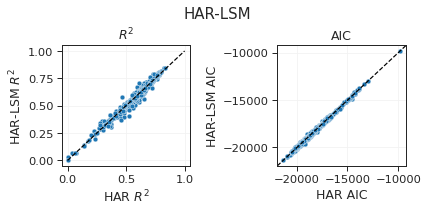

In [80]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2)
fig.suptitle('HAR-LSM')

ax = axs[0]
sns.scatterplot(x="rsquared_har", y="rsquared_har_ls", data=results_df, ax=ax)
ax.plot([0, 1], [0, 1], color="k", ls="dashed")
ax.set_ylabel('HAR-LSM $R^2$')
ax.set_xlabel('HAR $R^2$')
ax.set_title('$R^2$')

ax = axs[1]
sns.scatterplot(x="aic_har", y="aic_har_ls", data=results_df, ax=ax)
ax.plot([0, 1], [0, 1], color="k", ls="dashed", transform=ax.transAxes)
ax.set_ylabel('HAR-LSM AIC')
ax.set_xlabel('HAR AIC')
ax.set_title('AIC')

plt.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig('../exhibits/final_paper/harlsm_r2.pdf')

In [81]:
r2_perf = np.mean(results_df['rsquared_har'] < results_df['rsquared_har_lsf'])
aic_perf = np.mean(results_df['aic_har'] > results_df['aic_har_lsf'])
print(r2_perf, aic_perf)

1.0 0.9824175824175824


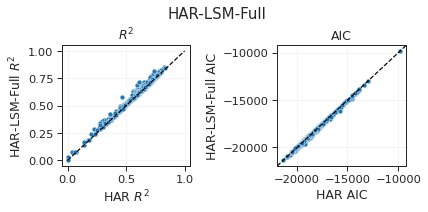

In [82]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2)
fig.suptitle('HAR-LSM-Full')

ax = axs[0]
sns.scatterplot(x="rsquared_har", y="rsquared_har_lsf", data=results_df, ax=ax)
ax.plot([0, 1], [0, 1], color="k", ls="dashed")
ax.set_ylabel('HAR-LSM-Full $R^2$')
ax.set_xlabel('HAR $R^2$')
ax.set_title('$R^2$')

ax = axs[1]
sns.scatterplot(x="aic_har", y="aic_har_lsf", data=results_df, ax=ax)
ax.plot([0, 1], [0, 1], color="k", ls="dashed", transform=ax.transAxes)
ax.set_ylabel('HAR-LSM-Full AIC')
ax.set_xlabel('HAR AIC')
ax.set_title('AIC')

plt.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig('../exhibits/final_paper/harlsmf_r2.pdf')

## Distribution of Coefficients

In [ ]:
print(
    results_df[[x for x in results_df.columns if "har_coeff" in x]]
    .describe(percentiles=[0.05, 0.25, 0.75, 0.95])
    .drop("count")
    .T.round(3)
    .to_latex()
)

In [ ]:
print(
    results_df[[x for x in results_df.columns if "harls_coeff" in x]]
    .describe(percentiles=[0.05, 0.25, 0.75, 0.95])
    .drop("count")
    .T.round(3)
    .to_latex()
)

In [ ]:
print(
    results_df[[x for x in results_df.columns if "harlsf_coeff" in x]]
    .describe(percentiles=[0.05, 0.25, 0.75, 0.95])
    .drop("count")
    .T.round(3)
    .to_latex()
)

## Movement of AR Components

In [ ]:
reg_cols = [x for x in results_df.columns if "harls_coeff_" in x]

In [ ]:
merged_df = data_rv_df.merge(results_df, on = 'ticker', how  ='left')

In [ ]:
reg_switch_cols = [
    x for x in results_df.columns if "harls_coeff_" in x and "switch" in x
]

merged_df["harls_persistence"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * merged_df[reg_switch_cols].sum(axis=1)

merged_df["harls_beta_1"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * merged_df['harls_coeff_rv_lag_1:switchn_lag_1']

In [ ]:
plt.figure(figsize = (12,5))
ticker = 'GS'
sns.lineplot(x = 'date', y = 'harls_persistence', data = merged_df.query('ticker == @ticker'))
sns.lineplot(x = 'date', y = 'persistence', data = merged_df.query('ticker == @ticker'))

### AR (1)

In [ ]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [ ]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_ar1_df = pd.concat(results)

#### 6 Tickers Set

In [ ]:
# Implied AR(1) coefficient estimate
fig, axs = plt.subplots(figsize=(14, 7), nrows = 3)
ticker_list = ["AMZN", 'AAPL', 'GOOG']

merged_df["harls_beta_1"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * (
    merged_df["harls_coeff_rv_lag_1:switchn_lag_1"]
#     + merged_df["harls_coeff_rv_lag_m5:switchn_lag_1"] / 5
#     + merged_df["harls_coeff_rv_lag_m22:switchn_lag_1"] / 22
)

# merged_df["rollcoef_AR1"] = (
#     merged_df["rv_lag_1_rollcoeff"]
#     + merged_df["rv_lag_m5_rollcoeff"] / 5
#     + merged_df["rv_lag_m22_rollcoeff"] / 22
# )

ax = axs[0]
for i in range(len(ticker_list)):
    ax = axs.reshape(-1)[i]
    ticker = ticker_list[i]
    sns.lineplot(
        x="date",
        y="rv_lag_1",
        label="Rolling $\\beta_{1,t}$ Estimate",
        color="k",
        alpha=0.8,
        data=rolling_ar1_df.query("ticker == @ticker"),
        ax = ax
    )
    sns.lineplot(
        x="date",
        y="harls_beta_1",
        lw=2,
        label="HAR-LSM $\\beta_{1,t}$  Estimate",
        data=merged_df.query("ticker == @ticker"),
        ax = ax
    )
    ax.set_xlabel('')
    ax.set_ylabel("$\\beta_{1,t}$ Estimate", fontsize = 14)
    ax.set_title('$' + ticker)
    if i > 0:
        ax.get_legend().remove()
    
plt.tight_layout()
plt.savefig('../exhibits/harlsm_beta1t_path.pdf')